In [49]:
import requests
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from skimpy import skim

## Table of Content:
* [Data Preparation & Visualisation](#data-prep-viz)
* [Machine Learning](#ml)

In [8]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data Preparation & Visualisation <a class="anchor" id="data-prep-viz"></a>

## Helper Functions

In [4]:
NUMPY_INTS = [numpy.dtypes.Float64DType,numpy.dtypes.Float32DType, numpy.dtypes.Int64DType, numpy.dtypes.Int32DType]

def fetch_data(url, out_file):
  res = requests.get(url)
  if res.content:
    with open(out_file, "w") as csv_file:
      writer = csv.writer(csv_file)
      content = res.content.decode("utf-8").split("\n")
      for line in content:
        line = [entry.replace('"', '').replace('\r', '') for entry in line.split(",")]
        writer.writerow(line)

# Returns a cleaned up dataframe
def do_basic_cleanup(df, drop_cols):
    try:
      df = df.drop(columns=drop_cols)
    except Exception as e:
      print(e)
    df = df.rename(columns={c: c.lower().replace(" ", "_").replace("(", "").replace(")", "") for c in df.columns})
    return df

# returns a series with Value counts, where ....
# https://www.kaggle.com/code/parulpandey/five-ways-to-use-value-counts
def value_counts(df):
    res = []
    for col in df.columns:
      preliminary_res = df[col].value_counts()
      if preliminary_res.size > 20:
        if type(df[col].dtype) in NUMPY_INTS:
          preliminary_res = df[col].value_counts(bins=10)
          preliminary_res.name = preliminary_res.name + "- BINNED"
        else:
          preliminary_res = df[col].value_counts(normalize=True)  
          preliminary_res.name = preliminary_res.name + "- NORMALIZED"
      res.append(preliminary_res)
    return res

def cast_cols_to_str(df, cols):
    for col in cols:
      df[col] = df[col].astype(str)


In [125]:
# Source: https://data.cso.ie/table/ASA02
fetch_data("https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/ASA02/CSV/1.0/en", "irl_tourism.csv")

In [126]:
df = pd.read_csv("irl_tourism.csv", on_bad_lines='warn')
df.head()

,STATISTIC,STATISTIC Label,TLIST(A1),Year,C02293V02763,Direction,C03042V03675,Route,UNIT,VALUE
0,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,-,All routes of travel,Thousand,12902.2
1,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,01,Cross channel,Thousand,6113.0
2,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,02,Continental Europe,Thousand,5652.6
3,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,03,Transatlantic,Thousand,914.5
4,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,04,Other,Thousand,222.1


In [127]:
df = do_basic_cleanup(df, ["STATISTIC", "STATISTIC Label", "TLIST(A1)", "C02293V02763", "C03042V03675", "UNIT"])

df = df.dropna()
df = df.astype({"year": int})
df.head()
df.tail()

,year,direction,route,value
0,2010,Arrivals,All routes of travel,12902.2
1,2010,Arrivals,Cross channel,6113.0
2,2010,Arrivals,Continental Europe,5652.6
3,2010,Arrivals,Transatlantic,914.5
4,2010,Arrivals,Other,222.1


,year,direction,route,value
135,2023,Departures,All routes of travel,20626.2
136,2023,Departures,Cross channel,7216.1
137,2023,Departures,Continental Europe,10485.0
138,2023,Departures,Transatlantic,2139.5
139,2023,Departures,Other,785.6


In [128]:
#df.apply(lambda col: col.value_counts(), axis=1)
#skim(df)
df['value'].value_counts(bins=7)
print(type(df['value'].dtype))

(128.722, 3074.486]       64
(5999.771, 8925.057]      33
(3074.486, 5999.771]      12
(11850.343, 14775.629]    10
(17700.914, 20626.2]       8
(8925.057, 11850.343]      7
(14775.629, 17700.914]     6
Name: count, dtype: int64

<class 'numpy.dtypes.Float64DType'>


## Looking at arrivals vs Departures 

In [129]:
arrivals = df[(df['direction'] == 'Arrivals') & (df['route'] != 'All routes of travel')]
departures = df[(df['direction'] == 'Departures') & (df['route'] != 'All routes of travel')]

In [130]:
arrivals.head()

,year,direction,route,value
1,2010,Arrivals,Cross channel,6113.0
2,2010,Arrivals,Continental Europe,5652.6
3,2010,Arrivals,Transatlantic,914.5
4,2010,Arrivals,Other,222.1
11,2011,Arrivals,Cross channel,6102.5


Text(0.5, 1.0, 'Number of Arrivals Into Ireland')

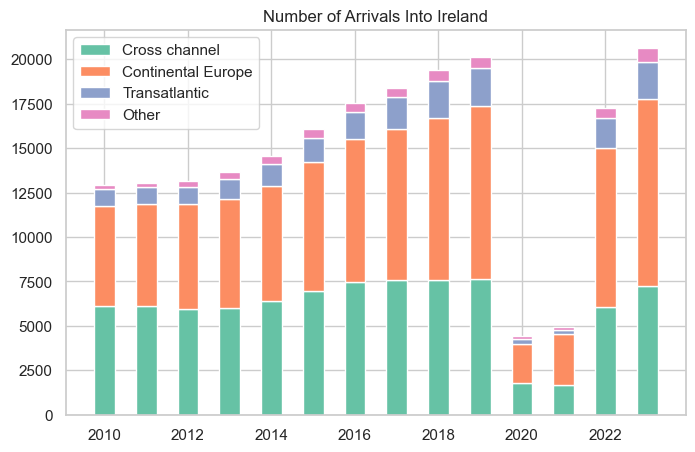

In [131]:
#sns.set_theme(style="whitegrid")

#ax = sns.barplot(data=arrivals, x="year", y="value", hue="route", palette='flare')

x = arrivals['year'].unique()
routes = arrivals['route'].unique()
bottom = np.zeros(len(x))
palette = sns.color_palette("Set2")

_, ax= plt.subplots(figsize=(8, 5))
width = 0.5

#for year in x:
for i, route in enumerate(routes):
   data = arrivals[arrivals['route'] == route]['value']
   _ = ax.bar(x, data, width, label=route, bottom=bottom, color=palette[i])
   bottom += data.to_numpy()

ax.set_title("Number of Arrivals Into Ireland")
ax.legend(loc="upper left")


In [134]:
departures['value']

6       6132.4
7       5643.3
8        924.3
9        220.3
16      6147.4
17      5779.8
18       950.9
19       231.5
26      5946.3
27      5899.9
28       974.6
29       340.7
36      6052.7
37      6113.5
38      1106.8
39       382.2
46      6437.7
47      6438.8
48      1260.3
49       433.8
56      6979.2
57      7238.3
58      1401.2
59       519.7
66      7531.9
67      8017.6
68      1577.8
69       480.9
76      7559.2
77      8501.1
78      1866.5
79       521.9
86      7599.3
87      9106.0
88      2136.9
89       614.1
96      7670.5
97      9715.8
98      2184.7
99       634.3
106     1858.9
107     2145.2
108      295.1
109      153.3
116     1757.5
117     2839.3
118      276.0
119      149.2
126     6016.7
127     8836.9
128     1773.1
129      545.7
136     7216.1
137    10485.0
138     2139.5
139      785.6
Name: value, dtype: float64

## Explore rate of change

In [262]:
arrivals_cols = arrivals.set_index(['year', 'route'])['value'].unstack().drop(columns=['All routes of travel'])
raw_cols = arrivals_cols.columns
new_cols = []
for c in arrivals_cols.columns.to_numpy():
    new_col = "ptc_ch_" + c.lower().replace(" ", "_")
    new_cols.append(new_col)
    arrivals_cols[new_col] = round(arrivals_cols[c].pct_change() * 100, 2)
arrivals_cols = arrivals_cols.drop(columns=raw_cols)
arrivals_cols = arrivals_cols.reset_index()
arrivals_cols.head()

route,year,ptc_ch_continental_europe,ptc_ch_cross_channel,ptc_ch_other,ptc_ch_transatlantic
0,2010,NaN,NaN,NaN,NaN
1,2011,2.30,-0.17,4.55,1.97
2,2012,2.38,-2.82,43.84,2.68
3,2013,3.72,1.44,14.85,14.16
4,2014,5.09,6.75,12.96,13.31


In [263]:
a = arrivals_cols.melt(id_vars=['year'], value_vars=new_cols)
a.head()

,year,route,value
0,2010,ptc_ch_continental_europe,NaN
1,2011,ptc_ch_continental_europe,2.30
2,2012,ptc_ch_continental_europe,2.38
3,2013,ptc_ch_continental_europe,3.72
4,2014,ptc_ch_continental_europe,5.09


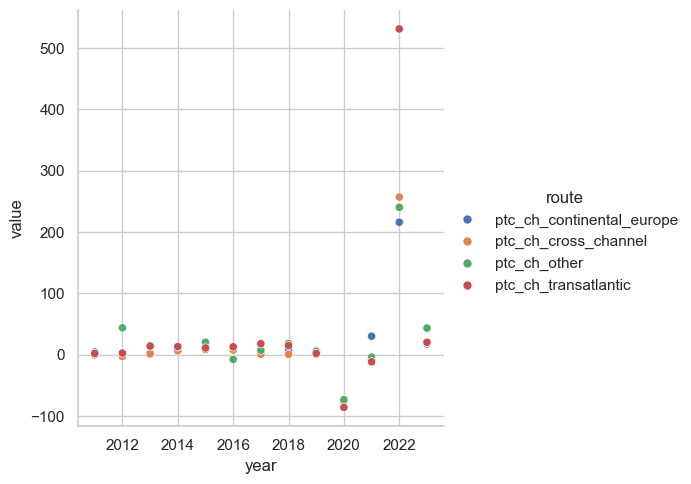

In [264]:
sns.relplot(data=a, x="year", y="value", hue="route")

## Flights to Ireland from other international airports
1. Data from https://ec.europa.eu/eurostat/web/transport/data/database
2. https://ec.europa.eu/eurostat/databrowser/explore/all/transp?lang=en&subtheme=avia.avia_pa.avia_par&display=list&sort=category&extractionId=avia_par_ie
3. Explanatory notes on the data https://ec.europa.eu/eurostat/databrowser/view/avia_par_ie/default/table?lang=en
4. API https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/dataflow/ESTAT/avia_par_ie$defaultview/1.0?references=descendants&detail=referencepartial&format=sdmx_2.1_generic&compressed=true

|Dimension	| Agency : Code list | Values |
| --- | --- | --- |
|FREQ | Time frequency	ESTAT : FREQ | Annual, Quarterly, Monthly ||
|UNIT | Unit of measure	ESTAT : UNIT | Passenger, Flights, Seats and berths||
|TRA_MEAS | Traffic and transport measurement	ESTAT : TRA_MEAS ||
|AIRP_PR | Airport pairs (routes)	ESTAT : AIRP_PR ||
|OBS_FLAG | Observation status (Flag)	ESTAT : OBS_FLAG ||

In [333]:
#IRL_AIRPORT_PASS_TRAVEL = "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/dataflow/ESTAT/avia_par_ie$defaultview/1.0?references=descendants&detail=referencepartial&format=sdmx_2.1_generic&compressed=true"
# https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/avia_par_ie/?format=SDMX-CSV&lang=en&label=both
# https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/avia_par_ie/?format=TSV
# https://ec.europa.eu/eurostat/databrowser/view/avia_par_ie/default/table?lang=en&category=avia.avia_pa.avia_par

# https://ec.europa.eu/eurostat/databrowser/view/avia_par_ie/default/table?lang=en&category=avia.avia_pa.avia_par
fetch_data("https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/avia_par_ie/1.0?compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name", "flights.csv")

In [201]:
# low_memory=False due to mixed datatypes
flights = pd.read_csv("flights.csv", low_memory=False)

In [202]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
#flights.columns
flights.head()

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,freq,Time frequency,unit,Unit of measure,tra_meas,Traffic and transport measurement,airp_pr,Airport pairs (routes),TIME_PERIOD,Time,OBS_VALUE,Observation value,OBS_FLAG,Observation status (Flag)
0,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_BE_EBBR,CORK airport - BRUSSELS airport,2012,NaN,256.0,NaN,NaN,NaN
1,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_BE_EBBR,CORK airport - BRUSSELS airport,2013,NaN,248.0,NaN,NaN,NaN
2,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_CH_LSZH,CORK airport - ZURICH airport,2019,NaN,213.0,NaN,NaN,NaN
3,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_CZ_LKPR,CORK airport - PRAHA/RUZYNE airport,2003,NaN,296.0,NaN,NaN,NaN
4,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_CZ_LKPR,CORK airport - PRAHA/RUZYNE airport,2004,NaN,557.0,NaN,NaN,NaN


In [203]:
# https://www.kaggle.com/code/parulpandey/five-ways-to-use-value-counts
flights = do_basic_cleanup(flights, ["STRUCTURE", "STRUCTURE_ID", "STRUCTURE_NAME", 
                                     "freq", 'unit', 'Time', 'Observation value', 'Observation status (Flag)', 'OBS_FLAG', 'tra_meas'])

In [204]:
flights.dtypes
value_counts(flights)

time_frequency                        object
unit_of_measure                       object
traffic_and_transport_measurement     object
airp_pr                               object
airport_pairs_routes                  object
time_period                           object
obs_value                            float64
dtype: object

[time_frequency
 Monthly      370798
 Quarterly    126827
 Annual        31623
 Name: count, dtype: int64,
 unit_of_measure
 Passenger           270142
 Seats and berths    129621
 Flight              129485
 Name: count, dtype: int64,
 traffic_and_transport_measurement
 Passengers carried                               46912
 Passengers carried (arrival)                     46826
 Passengers carried (departures)                  46783
 Passengers on board                              43279
 Passengers seats available                       43279
 Commercial passenger air flights                 43228
 Passengers on board (arrivals)                   43188
 Passengers seats available (arrivals)            43188
 Passengers on board (departures)                 43154
 Passengers seats available (departures)          43154
 Commercial passenger air flights (arrivals)      43143
 Commercial passenger air flights (departures)    43114
 Name: count, dtype: int64,
 airp_pr
 IE_EIDW_UK_EGSS    

In [206]:
flights_m = flights[flights['time_frequency'] == 'Monthly']

In [209]:
flights_m[['year', 'quarter']] = flights_m['time_period'].str.split('-', expand=True)
flights_m = flights_m.drop(columns=['time_period'])

/var/folders/z7/8n2dlxg16tggjrtnz6s70x180000gn/T/ipykernel_43312/1491549800.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_m[['year', 'quarter']] = flights_m['time_period'].str.split('-', expand=True)
/var/folders/z7/8n2dlxg16tggjrtnz6s70x180000gn/T/ipykernel_43312/1491549800.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_m[['year', 'quarter']] = flights_m['time_period'].str.split('-', expand=True)


In [208]:
#flights_m[['year', 'quarter']] = flights_m['time_period'].str.split('-', expand=True)
flights_m[['domestic_airpot', 'international_airport']] = flights_m['airp_pr'].str.split('-', expand=True)

/var/folders/z7/8n2dlxg16tggjrtnz6s70x180000gn/T/ipykernel_43312/958757053.py:2: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  flights_m[['domestic_airpot', 'international_airport']] = flights_m['time_period'].apply(lambda x: x.split('-') if len(x.split('-')) == 2 else "", "")


ValueError: Columns must be same length as key

In [193]:
passengers_arr_month = flights_m.loc[(flights_m['unit_of_measure'] == 'Passenger') & (flights_m['traffic_and_transport_measurement'] == 'Passengers on board (arrivals)')]
passengers_dep_month = flights_m.loc[(flights_m['unit_of_measure'] == 'Passenger') & (flights_m['traffic_and_transport_measurement'] == 'Passengers on board (departures)')]

flights_arr_month = flights_m.loc[(flights_m['unit_of_measure'] == 'Flight') & (flights_m['traffic_and_transport_measurement'] == 'Commercial passenger air flights (arrivals)')]
flights_dep_month = flights_m.loc[(flights_m['unit_of_measure'] == 'Flight') & (flights_m['traffic_and_transport_measurement'] == 'Commercial passenger air flights (departures)')]

#flights_pass_q = flights_pass_q.drop(columns=['time_frequency', 'unit_of_measure', 'traffic_and_transport_measurement', 'tra_meas', 'obs_flag'])
# flights_pass_q.head()
# flights_pass_q.size
# https://store.icao.int/en/location-indicators-doc-7910 to map to 

In [196]:
passengers_arr_month.head()
passengers_dep_month.head()
# flights_arr_month.head()
# flights_dep_month.head()

passengers_arr_month.shape
passengers_dep_month.shape
flights_arr_month.shape
flights_dep_month.shape

,time_frequency,unit_of_measure,traffic_and_transport_measurement,airp_pr,airport_pairs_routes,obs_value,year,quarter
152840,Monthly,Passenger,Passengers on board (arrivals),IE_EICK_BE_EBBR,CORK airport - BRUSSELS airport,271.0,2012,03
152841,Monthly,Passenger,Passengers on board (arrivals),IE_EICK_BE_EBBR,CORK airport - BRUSSELS airport,1346.0,2012,04
152842,Monthly,Passenger,Passengers on board (arrivals),IE_EICK_BE_EBBR,CORK airport - BRUSSELS airport,1377.0,2012,05
152843,Monthly,Passenger,Passengers on board (arrivals),IE_EICK_BE_EBBR,CORK airport - BRUSSELS airport,1082.0,2012,06
152844,Monthly,Passenger,Passengers on board (arrivals),IE_EICK_BE_EBBR,CORK airport - BRUSSELS airport,1550.0,2012,07


,time_frequency,unit_of_measure,traffic_and_transport_measurement,airp_pr,airport_pairs_routes,obs_value,year,quarter
183148,Monthly,Passenger,Passengers on board (departures),IE_EICK_BE_EBBR,CORK airport - BRUSSELS airport,307.0,2012,03
183149,Monthly,Passenger,Passengers on board (departures),IE_EICK_BE_EBBR,CORK airport - BRUSSELS airport,1321.0,2012,04
183150,Monthly,Passenger,Passengers on board (departures),IE_EICK_BE_EBBR,CORK airport - BRUSSELS airport,1344.0,2012,05
183151,Monthly,Passenger,Passengers on board (departures),IE_EICK_BE_EBBR,CORK airport - BRUSSELS airport,1152.0,2012,06
183152,Monthly,Passenger,Passengers on board (departures),IE_EICK_BE_EBBR,CORK airport - BRUSSELS airport,1383.0,2012,07


(30308, 8)

(30271, 8)

(30269, 8)

(30238, 8)

In [ ]:
#sns.lineplot(data=flights_pass_q, x="time_period", y="obs_value", hue="airp_pr")

In [142]:
# res = requests.get('https://gist.githubusercontent.com/ssskip/5a94bfcd2835bf1dea52/raw/3b2e5355eb49336f0c6bc0060c05d927c2d1e004/ISO3166-1.alpha2.json')
# take this maybe?

res = requests.get('https://gist.githubusercontent.com/fogonwater/bc2b98baeb2aa16b5e6fbc1cf3d7d545/raw/6fd2951260d8f171181a45d2f09ee8b2c7767330/countries.json')
country_codes = json.loads(res.content.decode("utf-8"))

In [339]:
flights_pass_q['country_code'] = flights_pass_q['airp_pr'].apply(
    lambda x: country_codes[x[8:10]]['country_name'] if x[8:10] in country_codes else x[8:10])

In [340]:
flights_pass_q['continent_name'] = flights_pass_q['airp_pr'].apply(
    lambda x: country_codes[x[8:10]]['continent_name'] if x[8:10] in country_codes else x[8:10])

In [342]:
grouped = flights_pass_q.groupby(['time_period', 'country_code', 'continent_name'], as_index=False)['obs_value'].sum()

In [343]:
pd.set_option('display.max_rows', 300)
value_counts(grouped)

[time_period
 2019-Q4    0.017553
 2019-Q3    0.017553
 2019-Q2    0.017553
 2019-Q1    0.016520
 2023-Q3    0.016004
 2023-Q1    0.016004
 2023-Q2    0.016004
 2022-Q3    0.015488
 2022-Q2    0.015488
 2022-Q1    0.015488
 2022-Q4    0.015488
 2018-Q4    0.015488
 2018-Q3    0.015488
 2018-Q2    0.015488
 2018-Q1    0.015488
 2017-Q3    0.014972
 2017-Q1    0.014972
 2017-Q2    0.014972
 2017-Q4    0.014972
 2016-Q4    0.014455
 2016-Q3    0.014455
 2016-Q2    0.014455
 2016-Q1    0.014455
 2015-Q1    0.013423
 2015-Q4    0.013423
 2015-Q3    0.013423
 2015-Q2    0.013423
 2014-Q4    0.012907
 2014-Q3    0.012907
 2014-Q2    0.012907
 2013-Q3    0.012390
 2012-Q4    0.012390
 2012-Q2    0.012390
 2013-Q4    0.012390
 2014-Q1    0.012390
 2012-Q3    0.012390
 2013-Q2    0.012390
 2012-Q1    0.011874
 2011-Q4    0.011874
 2011-Q3    0.011874
 2013-Q1    0.011874
 2021-Q4    0.011874
 2011-Q2    0.011874
 2021-Q2    0.011874
 2021-Q3    0.011874
 2011-Q1    0.011358
 2010-Q3    0.011358


In [345]:
grouped[['year', 'quarter']] = grouped['time_period'].str.split('-', expand=True)

In [347]:
grouped_by_year = grouped.groupby(['year', 'continent_name'], as_index=False)['obs_value'].sum()
grouped_by_year.head()

,year,continent_name,obs_value
0,2003,EL,10185.0
1,2003,Europe,3571720.0
2,2003,North America,668190.0
3,2003,UK,4629760.0
4,2004,Europe,3867680.0


<Axes: xlabel='year', ylabel='obs_value'>

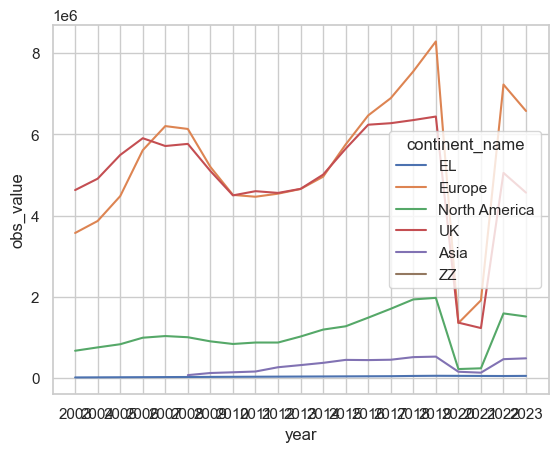

In [348]:
# fig, ax = plt.subplots()
# ax2 = ax.twins()
#  fig, ax = plt.subplots()
#     sb.regplot(x='round', y='money', data=firm, ax=ax)
#     ax2 = ax.twinx()
#     sb.regplot(x='round', y='dead', data=firm, ax=ax2, color='r')
#     sb.plt.show()
sns.lineplot(data=grouped_by_year, x='year', y='obs_value', hue='continent_name')

## Machine Learning <a class="anchor" id="ml"></a>


In [ ]:
import numpy as np
from sklearn.preprocessing import scale, StandardScaler

# Generating example data with different scales
data = np.array([[1.0, 20.0, 300.0],
                 [4.0, 50.0, 600.0],
                 [7.0, 80.0, 900.0]])

print("Original data:\n", data)

# Method 1: Scaling using the scale function
scaled_data = scale(data)
print("\nScaled data using scale function:\n", scaled_data)

# Method 2: Using StandardScaler
scaler = StandardScaler()
standardized_data = scaler.fit_transform(data)
print("\nStandardized data using StandardScaler:\n", standardized_data)

In [ ]:
# Model building

# instantiate an object of class SVC()
# note that we are using cost C=1
model = SVC(C = 1)

# fit
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

print(y_pred)